<a href="https://colab.research.google.com/github/mathfish/LearningTopics/blob/main/Books/PytorchMastery/TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import matplotlib.pyplot as plt
from torch import nn

try:
  import torchvision
except:
  !pip install torchvision
  import torchvision

from torchvision import transforms

try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary

try:
    from going_modular.going_modular import data_setup, engine
except:
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

try:
    from helper_functions import plot_loss_curves
except:
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

import os
from pathlib import Path
import zipfile
import requests
from timeit import default_timer as timer
from typing import List, Tuple
from PIL import Image
import random

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Get Data

In [ ]:
# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [ ]:
# Create train and test datasets in standard formats

train_dir = image_path / "train"
test_dir = image_path / "test"

# Transformations

In order to use pre-trained models, you need to setup data preparation in the same way as the model was trained (ideally). For some transformations, normalizing by a set number, this can be found by the NN but often it is faster to do it manually if specified in the documentation

## Manual Transformation

In [ ]:
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # Normalize across each color channel
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7d890de138e0>,
 ['pizza', 'steak', 'sushi'])

## Transformation - Auto Creation

As of `torchvision v0.13+` an automatic transform creation feature is available

In [ ]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [ ]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7d890c4e2350>,
 ['pizza', 'steak', 'sushi'])

# Pre-Trained Model

Many pretrained vision models found in `torchvision.models`
* resnet18 and resnet 50
* vgg16
* efficientnet_b0 and efficientnet_b1
* vit_b_16 and vit_b_32
* convnext_tiny and convnext_small

In [ ]:
'''
Model has 3 parts
- features: base layers that learn different features of images
- avgpool: averages the ouptut of the features layers and turns it into a feature vector
- classifier: turns feature vector inot a vector of the same demensionality as the number of needed output classes.
'''

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # best available weights
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 116MB/s]


In [ ]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

## Freeze Base Model

Freeze some base layers and change the classifier layer

In [ ]:
# freeze feature layers

for param in model.features.parameters():
  param.requires_grad = False

In [ ]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = len(class_names)
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,  out_features=3, bias=True)
).to(device)


In [ ]:
summary(model=model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## Train Model

In [ ]:
# loss function
loss_fn = torch.nn.CrossEntropyLoss()
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=50,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5413 | train_acc: 0.9141 | test_loss: 0.5434 | test_acc: 0.8759
Epoch: 2 | train_loss: 0.4583 | train_acc: 0.9336 | test_loss: 0.5219 | test_acc: 0.8655
Epoch: 3 | train_loss: 0.4375 | train_acc: 0.9062 | test_loss: 0.5266 | test_acc: 0.8352
Epoch: 4 | train_loss: 0.4668 | train_acc: 0.8281 | test_loss: 0.4599 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.4135 | train_acc: 0.8320 | test_loss: 0.4728 | test_acc: 0.8456
Epoch: 6 | train_loss: 0.4186 | train_acc: 0.8281 | test_loss: 0.4505 | test_acc: 0.8561
Epoch: 7 | train_loss: 0.3860 | train_acc: 0.9453 | test_loss: 0.4367 | test_acc: 0.8456
Epoch: 8 | train_loss: 0.3998 | train_acc: 0.8438 | test_loss: 0.4333 | test_acc: 0.8769
Epoch: 9 | train_loss: 0.4890 | train_acc: 0.8281 | test_loss: 0.4325 | test_acc: 0.8561
Epoch: 10 | train_loss: 0.3901 | train_acc: 0.8320 | test_loss: 0.3728 | test_acc: 0.9062
Epoch: 11 | train_loss: 0.3238 | train_acc: 0.9570 | test_loss: 0.3986 | test_acc: 0.8456
Epoch: 12 | train_l

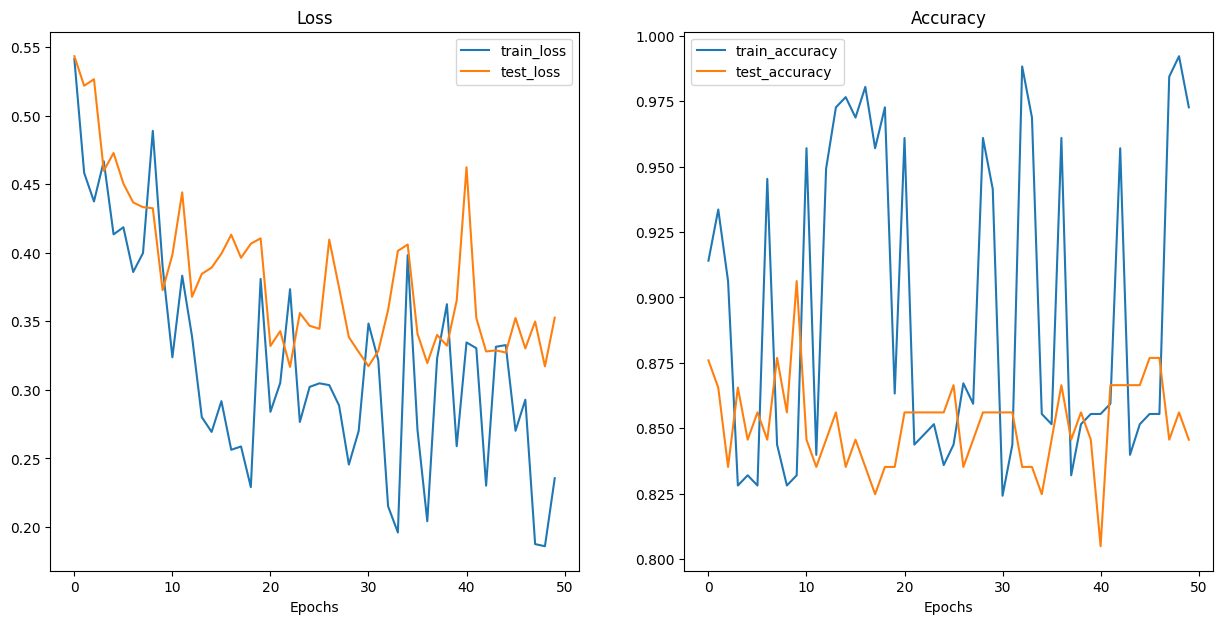

In [ ]:
# Plot the loss curves of our model
plot_loss_curves(results)

In [ ]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int]=(224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):

  img = Image.open(image_path)

  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

  model.to(device)

  model.eval()
  with torch.inference_mode():
    transformed_image = image_transform(img).unsqueeze(dim=0)
    target_image_pred = model(transformed_image.to(device))

  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  plt.figure()
  plt.imshow(img)
  plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
  plt.axis(False)

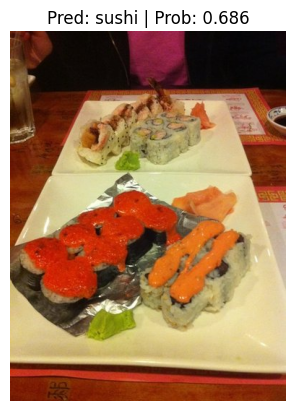

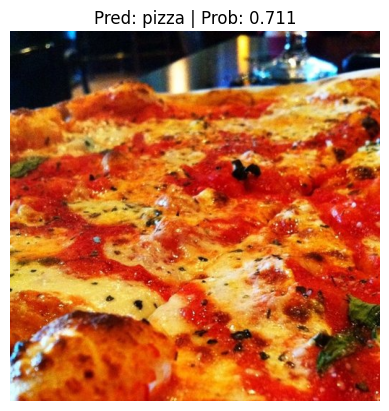

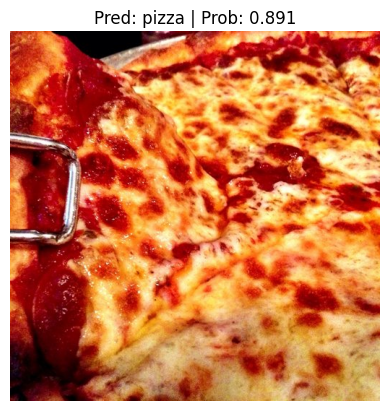

In [ ]:
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(population=test_image_path_list, k=num_images_to_plot)

for image_path in test_image_path_sample:
  pred_and_plot_image(model=model,
                      image_path=image_path,
                      class_names=class_names)